Best Model: RandomForestRegressor(n_estimators=200, random_state=42)
Root Mean Squared Error: 1.858412029417661


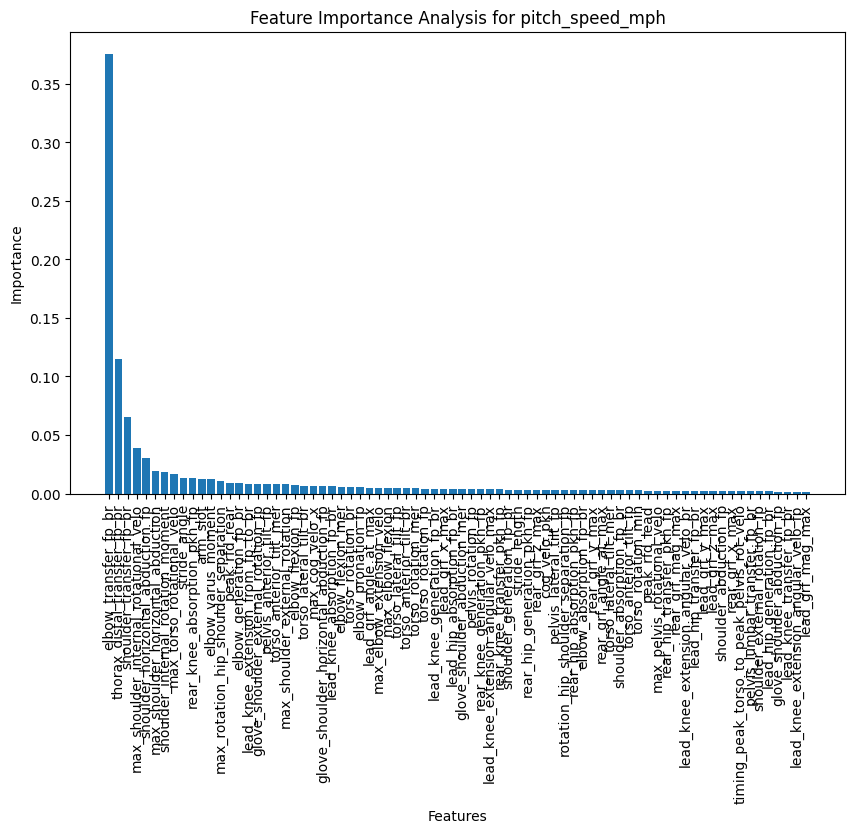

Selected Top Features: ['elbow_transfer_fp_br', 'thorax_distal_transfer_fp_br', 'shoulder_transfer_fp_br', 'max_shoulder_internal_rotational_velo', 'shoulder_horizontal_abduction_fp']
Correlation Matrix:
                                       elbow_transfer_fp_br  \
elbow_transfer_fp_br                               1.000000   
thorax_distal_transfer_fp_br                       0.927176   
shoulder_transfer_fp_br                            0.958231   
max_shoulder_internal_rotational_velo              0.003687   
shoulder_horizontal_abduction_fp                   0.296453   
pitch_speed_mph                                    0.690945   

                                       thorax_distal_transfer_fp_br  \
elbow_transfer_fp_br                                       0.927176   
thorax_distal_transfer_fp_br                               1.000000   
shoulder_transfer_fp_br                                    0.976877   
max_shoulder_internal_rotational_velo                     -0.043663   

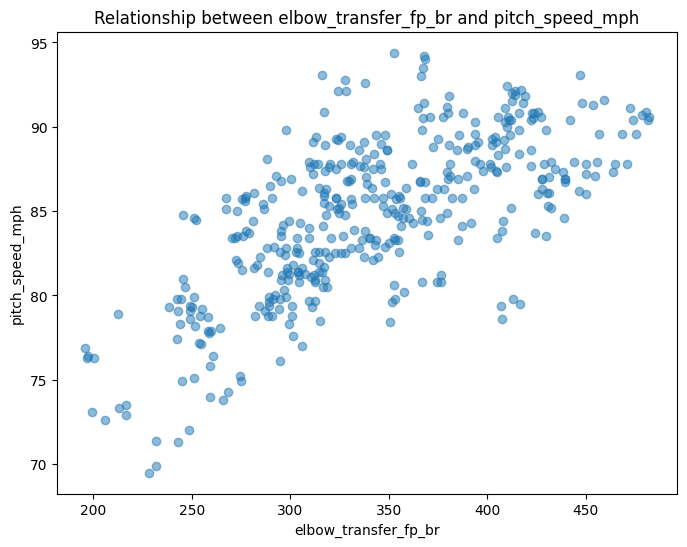

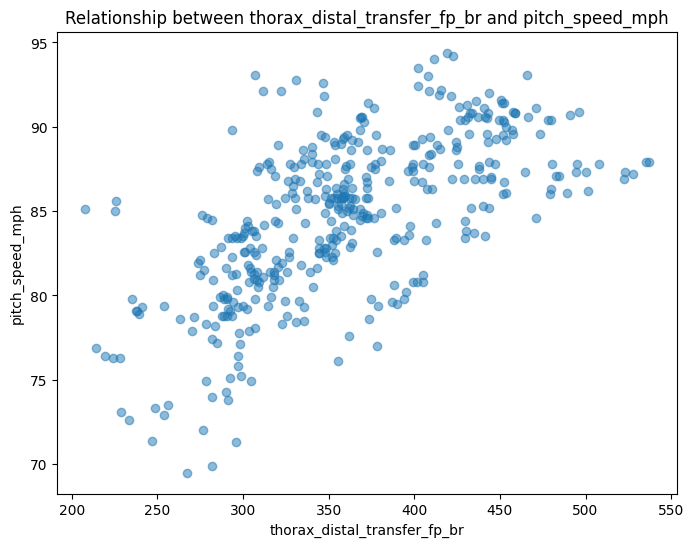

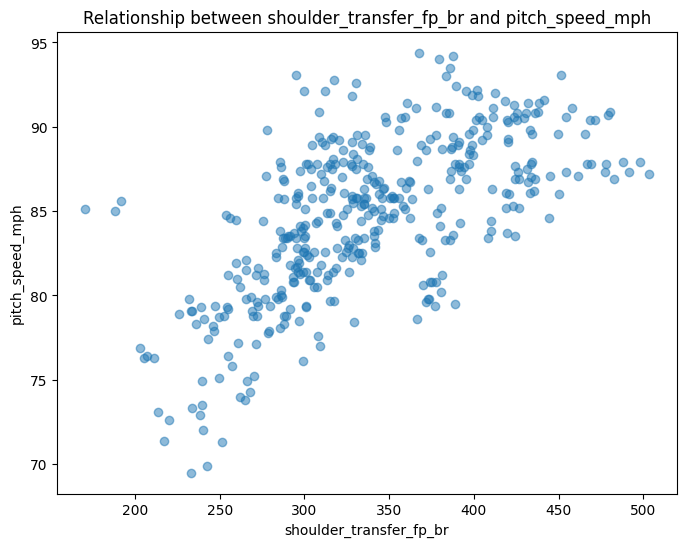

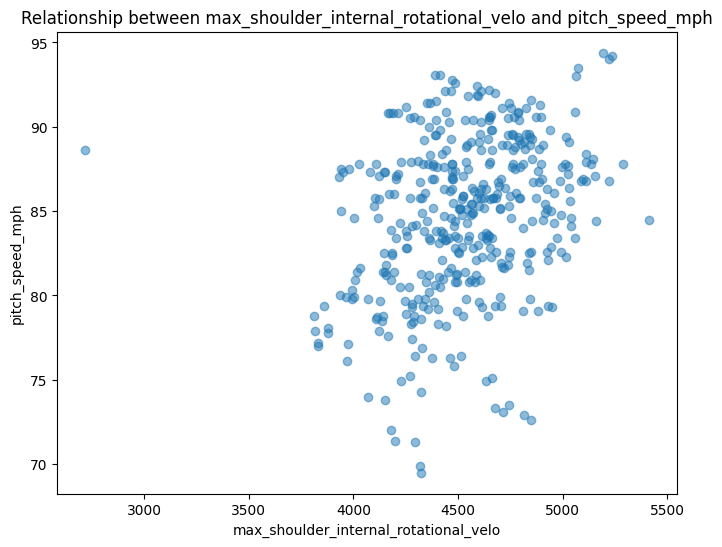

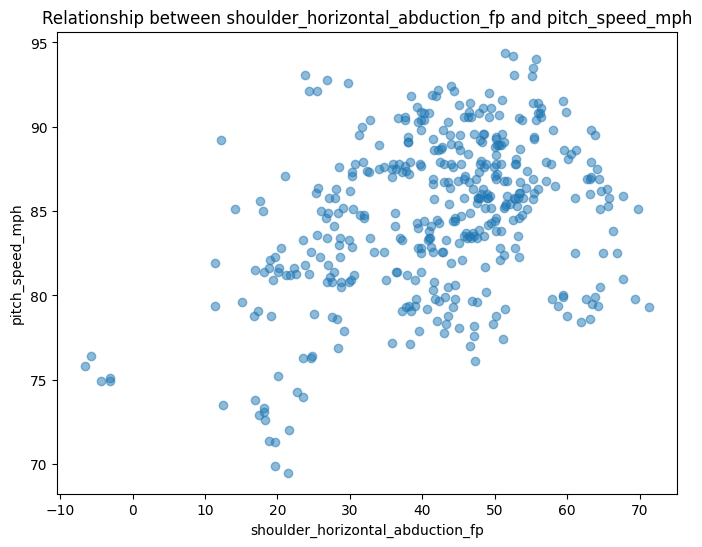

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Load data from CSV into a pandas DataFrame
data = pd.read_csv('poi_metrics.csv')

# Drop columns that are not needed for analysis
data = data.drop(['session_pitch', 'session', 'p_throws', 'pitch_type'], axis=1)

# Split data into features (X) and target variable (y)
X = data.drop('pitch_speed_mph', axis=1)
y = data['pitch_speed_mph']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Feature selection
selector = SelectKBest(score_func=f_regression, k='all')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Model selection and hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_selected, y_train)

# Evaluate the model on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("Best Model:", best_model)
print("Root Mean Squared Error:", rmse)

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances with corresponding feature names
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Analysis for pitch_speed_mph')
plt.show()

# Select top N important features
top_n_features = 5
selected_features = importance_df.head(top_n_features)['Feature'].tolist()

# Print selected features
print("Selected Top Features:", selected_features)

# Calculate correlation coefficients between selected features and pitch_speed_mph
correlations = data[selected_features + ['pitch_speed_mph']].corr()
print("Correlation Matrix:")
print(correlations)

# Analyze relationships between selected features and pitch_speed_mph
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[feature], data['pitch_speed_mph'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('pitch_speed_mph')
    plt.title(f'Relationship between {feature} and pitch_speed_mph')
    plt.show()

# Engineer new features based on the selected ones
data['interaction_feature'] = data[selected_features[0]] * data[selected_features[1]]
